<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
path_dir = 'gdrive/My Drive/Year4/Project/top_view/Case10_2018_09_29_Coor(5_2)/'

path = []

for p in os.listdir(path_dir):
  # print(p)
  path.append(p)

sorted(path)
path[0:10]


['21-20-05.png',
 '21-20-55.png',
 '21-20-15.png',
 '21-20-35.png',
 '21-20-45.png',
 '21-20-25.png',
 '21-21-25.png',
 '21-21-15.png',
 '21-21-05.png',
 '21-21-35.png']

In [0]:
from google.colab.patches import cv2_imshow

def plot_img(image):
  cv2_imshow(image)

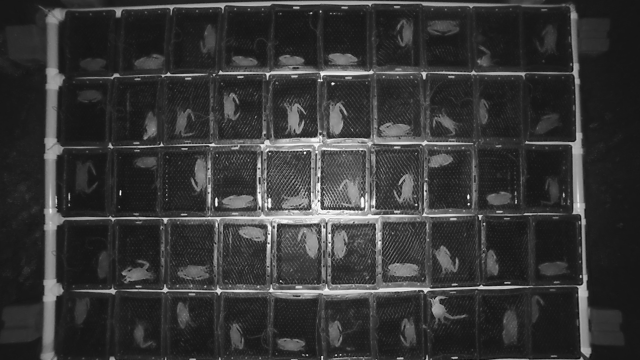

In [5]:
import cv2 as cv

data = []

for p in path:
  img = cv.imread(path_dir+'/'+p)
  shape = img.shape
  img_resize = cv.resize(img,(int(shape[1]/2),int(shape[0]/2)))
  data.append(img_resize)

plot_img(data[0])
# data[0].shape

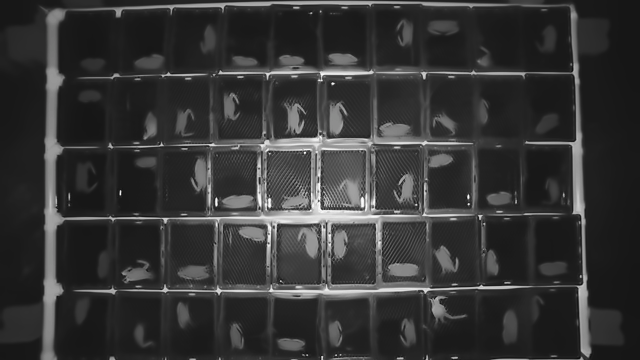

In [6]:
img = cv.fastNlMeansDenoisingColored(data[0],None,10,10,7,21)
plot_img(img)

In [0]:
img.shape

(360, 640, 3)

(360, 640)


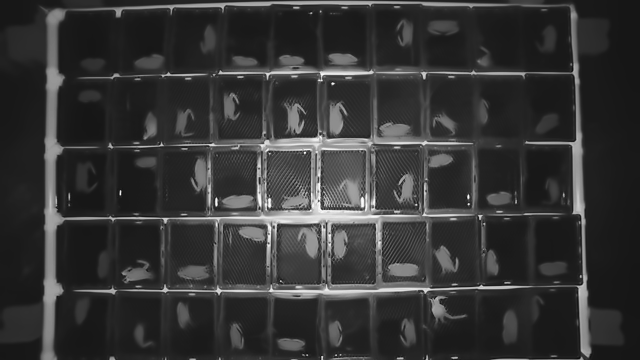

In [7]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
print(gray.shape)
plot_img(gray)

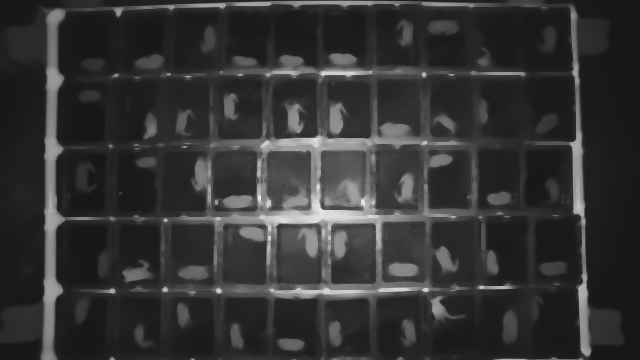

In [18]:
gray2 = cv.medianBlur(gray, 5)
plot_img(gray2)

In [30]:
print('min:',np.min(gray2))
print('max:',np.max(gray2))
print('avg:',np.mean(gray2))

min: 22
max: 232
avg: 51.92862847222222


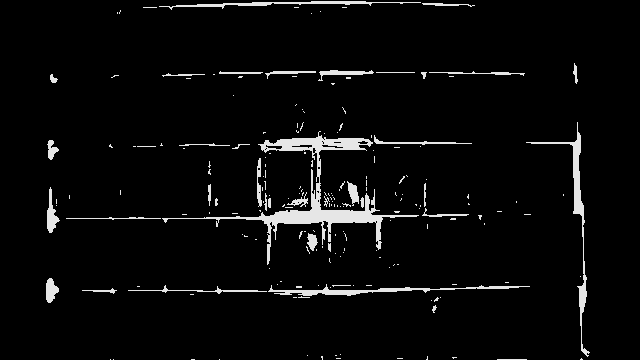

In [40]:
_, th1 = cv.threshold(gray,150, 230,cv.THRESH_BINARY)
# kernel = np.ones((5,5),np.uint8)
# erosion = cv.erode(th1,kernel,iterations=7)
# dilation = cv.dilate(erosion,kernel,iterations=2)

plot_img(th1)

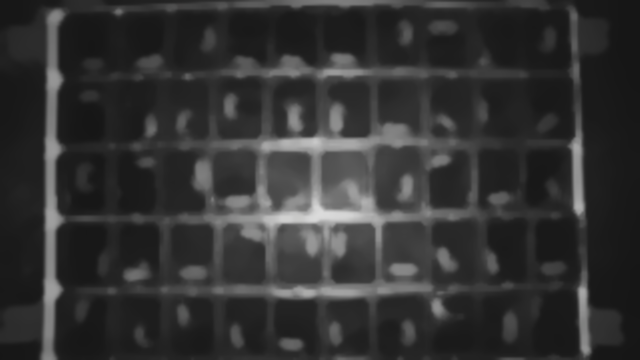

In [41]:
temp1 = cv.pyrDown(img)
gray2 = cv.medianBlur(temp1, 5)
temp2 = cv.pyrUp(gray2)
plot_img(temp2)

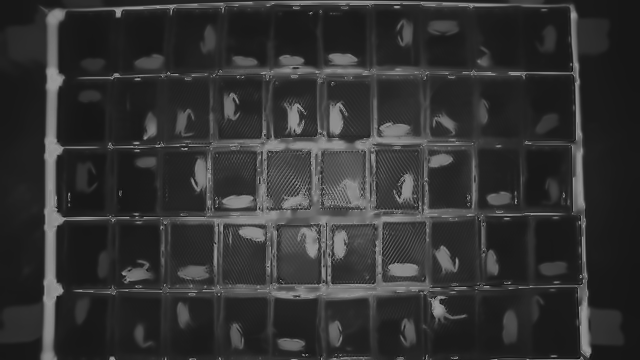

In [43]:
dst = cv.inpaint(gray,th1,9,cv.INPAINT_NS)
plot_img(dst)
# gray2.shape

In [0]:
src = gray2
src_col, src_row = src.shape[0], src.shape[1]
brightness = np.sum(src) / (255 * src_col * src_row)
minimum_brightness = 0.8
dest = cv.convertScaleAbs(src, alpha=minimum_brightness / brightness, beta=0)
dest.shape
# plot_img(dest)

(180, 320, 3)

In [0]:
print('min:',np.min(dest))
print('max:',np.max(dest))
print('avg:',np.mean(dest))

min: 29
max: 255
avg: 67.8701099537037


In [0]:
gray[0][0]

23

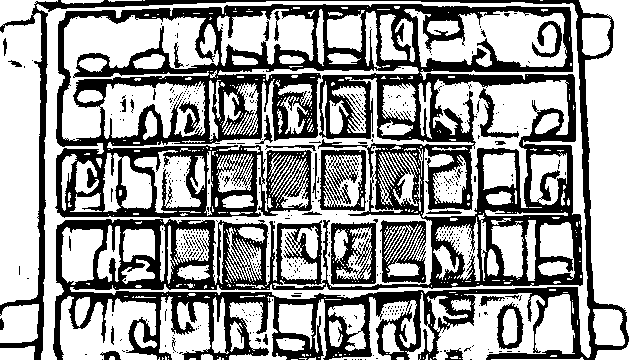

In [0]:
th1 = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
plot_img(th1)

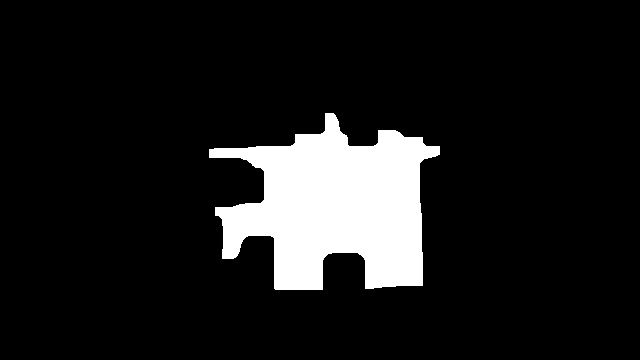

In [0]:
_, th1 = cv.threshold(temp2,50, 255,cv.THRESH_BINARY)

kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(th1,kernel,iterations=7)
dilation = cv.dilate(erosion,kernel,iterations=2)

plot_img(dilation)
# th2 = cv.cvtColor(gray2, cv.COLOR_GRAY2RGB)
# plot_img(th2)